Importing commonly used libraries for future use throughout the assignment

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import time
import pandas as pd
# Forming a manual seed for reproducibility using my ucard number
torch.manual_seed(1748942) 

## B2.1a
Loading the dataset 


In [2]:
batchSize=32
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
#Load the training data
trainset = datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True)
#Load the test data
testset = datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, 
                                         shuffle=False)

classes = ('top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')
# Verifying the training and test set sizes
print('Training set size:', len(trainset))
print('Test set size:',len(testset))

Training set size: 60000
Test set size: 10000


In [3]:
# Splitting trainset into images & labels
# where x = images
# y = labels
X, y = trainset.data, trainset.targets
X.shape
y.shape

torch.Size([60000])

## B2.1b

Display at least 8 images of each class

In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()


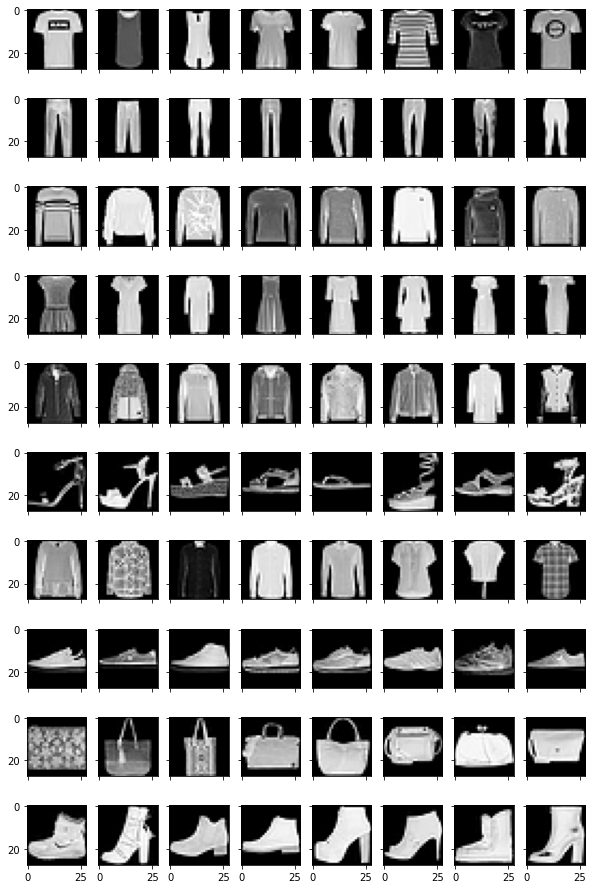

In [5]:
X, y = trainset.data, trainset.targets

classes = {}

for i in range(10):
    classes[i] = np.where(y==i)[0][:8]
    
fig, ax = plt.subplots(10, 8, figsize=(10, 16), sharex='col', sharey='row')
for i in range(10):
    for j in range(8):
        ax[i, j].imshow(X[classes[i][j]].reshape(28,28), cmap='gray')
        
    

## B2.3a

Train a logistic regression model on the training set & test the model on the test set.


In [6]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim, penalty, solver):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)    
        
    def forward(self, x):
            y_pred = torch.sigmoid(self.linear(x))
            return y_pred    

In [7]:
max_epochs = 3
input_dim = 784
output_dim = 10
lr_rate = 0.01

In [8]:
LR = LogisticRegression(input_dim, output_dim, penalty='none', solver='lbfgs')

In [9]:
criterion = torch.nn.CrossEntropyLoss()

In [10]:
optimizer = torch.optim.SGD(LR.parameters(), lr=lr_rate)

In [11]:
torch.manual_seed(1748942)
iter = 0
start = time.time()
for epoch in range(max_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        
        outputs = LR(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            # calculate Accuracy on the training set
            correct = 0
            total = 0
            for images, labels in trainloader:
                images = Variable(images.view(-1, 28*28))
                outputs = LR(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                correct+= (predicted == labels).sum()
LR_train_acc = 100 * correct/total

print('Accuracy: %.3f' % (LR_train_acc))

stop = time.time()
LR_train_time = stop - start
print(f"Training time: {stop - start}s")

C:\Users\Euan\anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Accuracy: 75.888
Training time: 130.2659149169922s


In [12]:
# Calculating the accuracy on the test data
correct = 0
total = 0
with torch.no_grad():  
    for data in testloader:
        images, labels = data
        images = Variable(images.view(-1, 28*28))
        outputs = LR(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
LR_test_acc = 100 * correct / total
print('Accuracy of the network on the 10000 test images: %.3f' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 75.060


In [13]:
# The number of learnable parameters

LR_params = list(LR.parameters())
print("len(LR_params):", len(LR_params))

len(LR_params): 2


In [14]:
Xtest, ytest = testset.data, testset.targets
Xtest.shape
ytest.shape

torch.Size([10000])

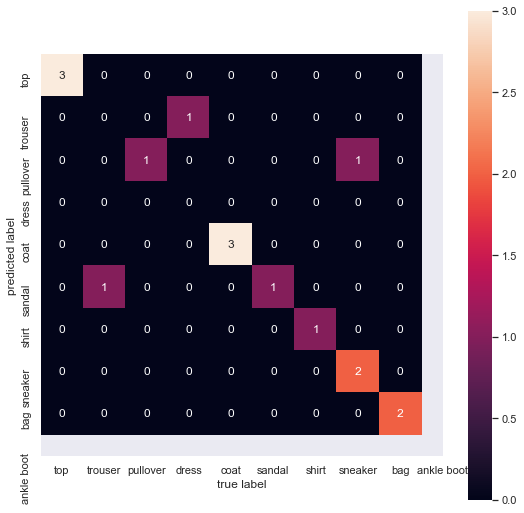

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
classes = ('top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')
plt.figure(figsize=(9,9))
y_true = labels
y_pred = predicted
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
           xticklabels= classes, yticklabels= classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

## B2.3b

Train & test a logistic regression model with L1 regularisation

In [16]:
LR_L1 = LogisticRegression(input_dim, output_dim, penalty='l1', solver='saga')
print(LR_L1)
optimizer = torch.optim.SGD(LR_L1.parameters(), lr=lr_rate)

LogisticRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [17]:
torch.manual_seed(1748942)
iter = 0
start = time.time()
for epoch in range(max_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = LR_L1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            # calculate Accuracy on the training set
            correct = 0
            total = 0
            for images, labels in trainloader:
                images = Variable(images.view(-1, 28*28))
                outputs = LR_L1(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                correct+= (predicted == labels).sum()
LR_L1_train_acc = 100 * correct/total
print('Accuracy: %.3f' % (100 * correct / total))
stop = time.time()
LR_L1_train_time = stop - start
print(f"Training time: {stop - start}s")

Accuracy: 75.932
Training time: 134.4107551574707s


In [18]:
# Calculating the accuracy on the test data
correct = 0
total = 0
with torch.no_grad(): 
    for data in testloader:
        images, labels = data
        images = Variable(images.view(-1, 28*28))
        outputs = LR_L1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
LR_L1_test_acc = 100 * correct / total
print('Accuracy of the network on the 10000 test images: %.3f' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 75.080


In [19]:
# The number of learnable parameters

LR_L1_params = list(LR_L1.parameters())
print("len(LR_L1_params):", len(LR_L1_params))

len(LR_L1_params): 2


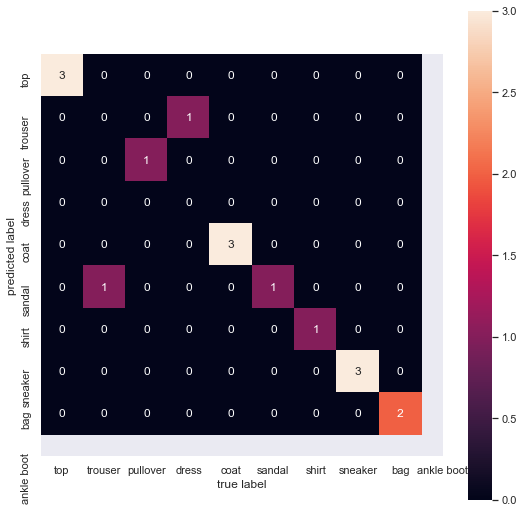

In [20]:
# Plotting a confusion matrix for the predictions of the test data

classes = ('top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')
plt.figure(figsize=(9,9))
y_true = labels
y_pred = predicted
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
           xticklabels= classes, yticklabels= classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

## B2.3c

Train & test a logistic regression model with L2 regularisation

In [21]:
LR_L2 = LogisticRegression(input_dim, output_dim, penalty='l2', solver='lbfgs')
print(LR_L2)
optimizer = torch.optim.SGD(LR_L2.parameters(), lr=lr_rate)

LogisticRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [22]:
torch.manual_seed(1748942)
iter = 0
start = time.time()
for epoch in range(max_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = Variable(images.view(-1, 28 * 28))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = LR_L2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            # calculate Accuracy on the training set
            correct = 0
            total = 0
            for images, labels in trainloader:
                images = Variable(images.view(-1, 28*28))
                outputs = LR_L2(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                correct+= (predicted == labels).sum()
LR_L2_train_acc = 100 * correct/total
print('Accuracy: %.3f' % (100 * correct / total))
stop = time.time()
LR_L2_train_time = stop - start
print(f"Training time: {stop - start}s")

Accuracy: 75.932
Training time: 138.52947902679443s


In [23]:
# Calculating the accuracy on the test data
correct = 0
total = 0
with torch.no_grad():  
    for data in testloader:
        images, labels = data
        images = Variable(images.view(-1, 28*28))
        outputs = LR_L2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
LR_L2_test_acc = 100 * correct / total
print('Accuracy of the network on the 10000 test images: %.3f' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 75.080


In [24]:
# The number of learnable parameters

LR_L2_params = list(LR_L2.parameters())
print("len(LR_L2_params):", len(LR_L2_params))

len(LR_L2_params): 2


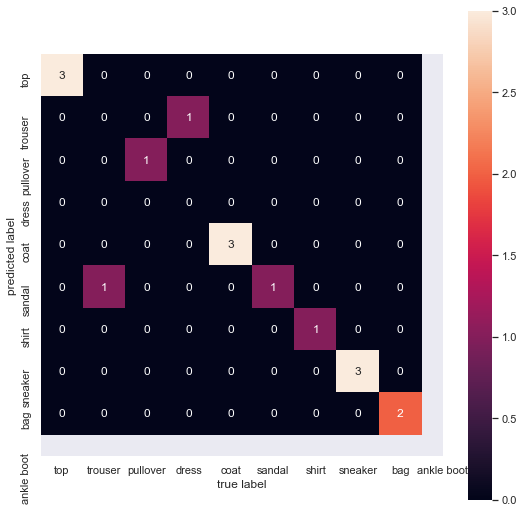

In [25]:
# Plotting a confusion matrix for the predictions of the test data

classes = ('top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')
plt.figure(figsize=(9,9))
y_true = labels
y_pred = predicted
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
           xticklabels= classes, yticklabels= classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

## B2.4a

Design a CNN with 2 Conv layers & 2 FC layers

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

CNN_a = CNN()
print(CNN_a)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_a.parameters(), lr=0.01, momentum=0.9)

In [28]:
torch.manual_seed(1748942)
iter = 0
max_epochs=3
start = time.time()
for epoch in range(max_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = CNN_a(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        iter+=1
        if iter%500==0:
            # calculate Accuracy on the training set
            correct = 0
            total = 0
            for images, labels in trainloader:
                outputs = CNN_a(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                correct+= (predicted == labels).sum()
CNN_a_train_acc = 100 * correct/total
print('Accuracy: %.3f' % (100 * correct / total))
stop = time.time()
CNN_a_train_time = stop - start
print(f"Training time: {stop - start}s")

Accuracy: 89.887
Training time: 212.5054862499237s


In [29]:
# Calculating the accuracy on the test data
correct = 0
total = 0
with torch.no_grad():  
    for data in testloader:
        images, labels = data
        outputs = CNN_a(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
CNN_a_test_acc = 100 * correct / total
print('Accuracy of the network on the 10000 test images: %.3f' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 87.310


In [30]:
CNN_a_params = list(CNN_a.parameters())
print("Number of learnable parameters:", len(CNN_a_params))

Number of learnable parameters: 8


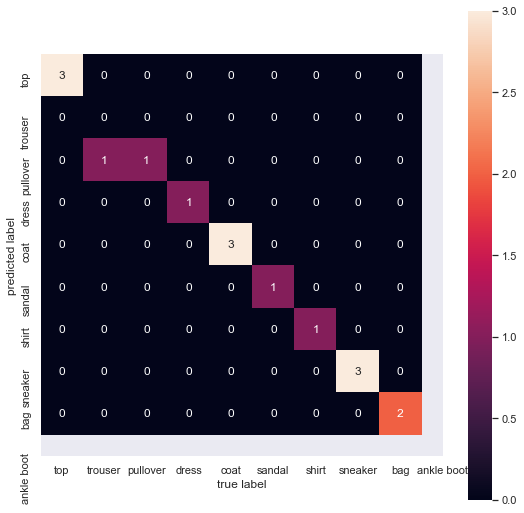

In [31]:
classes = ('top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')
plt.figure(figsize=(9,9))
y_true = labels
y_pred = predicted
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
           xticklabels= classes, yticklabels= classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

## B2.4b

Design a CNN with 2 Conv layers & 5 FC layers

In [32]:
class CNN_b(nn.Module):
    def __init__(self):
        super(CNN_b, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 180)
        self.fc2 = nn.Linear(180, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 56)
        self.fc5 = nn.Linear(56, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
CNN_b = CNN_b()
print(CNN_b)

CNN_b(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=180, bias=True)
  (fc2): Linear(in_features=180, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=56, bias=True)
  (fc5): Linear(in_features=56, out_features=10, bias=True)
)


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_b.parameters(), lr=0.01, momentum=0.9)

In [34]:
torch.manual_seed(1748942)
iter = 0
max_epochs=3
start = time.time()
for epoch in range(max_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = CNN_b(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            # calculate Accuracy on the training set
            correct = 0
            total = 0
            for images, labels in trainloader:
                outputs = CNN_b(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                correct+= (predicted == labels).sum()
CNN_b_train_acc = 100 * correct/total

print('Accuracy: %.3f' % (100 * correct / total))
stop = time.time()
CNN_b_train_time = stop - start
print(f"Training time: {stop - start}s")

Accuracy: 88.258
Training time: 206.00788640975952s


In [35]:
# Calculating the accuracy on the test data
correct = 0
total = 0
with torch.no_grad():  
    for data in testloader:
        images, labels = data
        outputs = CNN_b(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
CNN_b_test_acc = 100 * correct / total
print('Accuracy of the network on the 10000 test images: %.3f' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 86.490


In [36]:
CNN_b_params = list(CNN_b.parameters())
print("Number of learnable parameters:", len(CNN_b_params))

Number of learnable parameters: 14


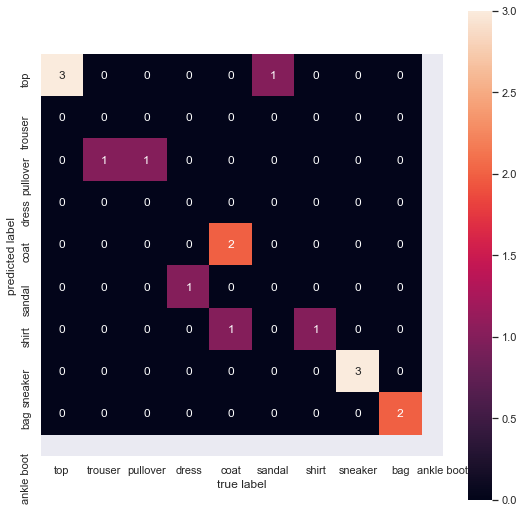

In [37]:
classes = ('top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')
plt.figure(figsize=(9,9))
y_true = labels
y_pred = predicted
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
           xticklabels= classes, yticklabels= classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

## B2.4c

Design a CNN with 5 Conv layers & 2 FC layers

In [38]:
x = torch.randn(32, 1, 28, 28)

In [39]:
class CNN_c(nn.Module):
    def __init__(self):
        super(CNN_c, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.conv3 = nn.Conv2d(16, 28, 5, padding=2)
        self.conv4 = nn.Conv2d(28, 44, 5, padding=2)
        self.conv5 = nn.Conv2d(44, 60, 5, padding=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

CNN_c = CNN_c()
print(CNN_c)

CNN_c(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 28, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(28, 44, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(44, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_c.parameters(), lr=0.01, momentum=0.9)

In [41]:
torch.manual_seed(1748942)
iter = 0
max_epochs=3
start = time.time()
for epoch in range(max_epochs):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = CNN_c(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        iter+=1
        if iter%500==0:
            # calculate Accuracy on the training set
            correct = 0
            total = 0
            for images, labels in trainloader:
                outputs = CNN_c(images)
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                correct+= (predicted == labels).sum()
CNN_c_train_acc = 100 * correct/total
print('Accuracy: %.3f' % (100 * correct / total))
stop = time.time()
CNN_c_train_time = stop - start
print(f"Training time: {stop - start}s")

Accuracy: 89.623
Training time: 187.5474317073822s


In [42]:
# Calculating the accuracy on the test data
correct = 0
total = 0
with torch.no_grad():  #testing phase, no need to compute the gradients to save time
    for data in testloader:
        images, labels = data
        outputs = CNN_c(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
CNN_c_test_acc = 100 * correct / total
print('Accuracy of the network on the 10000 test images: %.3f' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 87.010


In [43]:
CNN_c_params = list(CNN_c.parameters())
print("Number of learnable parameters:", len(CNN_c_params))

Number of learnable parameters: 14


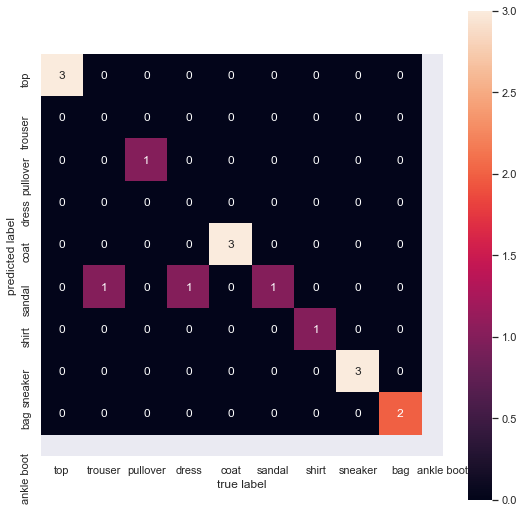

In [44]:
classes = ('top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')
plt.figure(figsize=(9,9))
y_true = labels
y_pred = predicted
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
           xticklabels= classes, yticklabels= classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

## B2.5 Performance Comparison

a) Bar graphs summarising the metrics

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

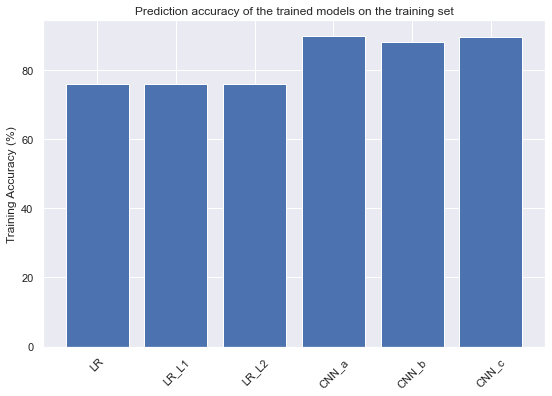

In [45]:
# For training set accuracy
labels = ['LR', 'LR_L1', 'LR_L2', 'CNN_a', 'CNN_b', 'CNN_c']
values = [LR_train_acc, LR_L1_train_acc, LR_L2_train_acc, CNN_a_train_acc, CNN_b_train_acc, CNN_c_train_acc]


plt.figure(figsize=(9,6))
 
plt.bar(x=labels,
 
        height=values)

plt.title('Prediction accuracy of the trained models on the training set')
plt.ylabel('Training Accuracy (%)')
 
plt.xticks(rotation=45)


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

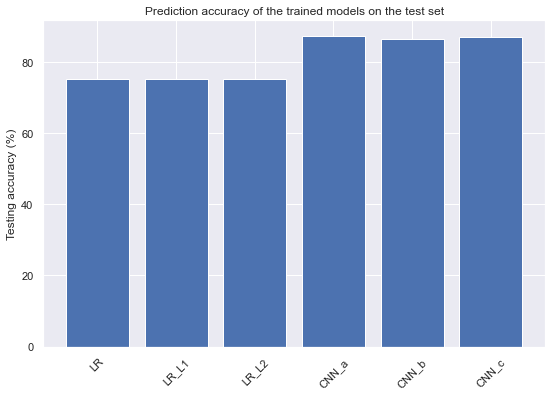

In [46]:
# For test set accuracy
labels = ['LR', 'LR_L1', 'LR_L2', 'CNN_a', 'CNN_b', 'CNN_c'] 
values = [LR_test_acc, LR_L1_test_acc, LR_L2_test_acc, CNN_a_test_acc, CNN_b_test_acc, CNN_c_test_acc]


plt.figure(figsize=(9,6))
 
plt.bar(x=labels,
 
        height=values)

plt.title('Prediction accuracy of the trained models on the test set')
plt.ylabel('Testing accuracy (%)')
 
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

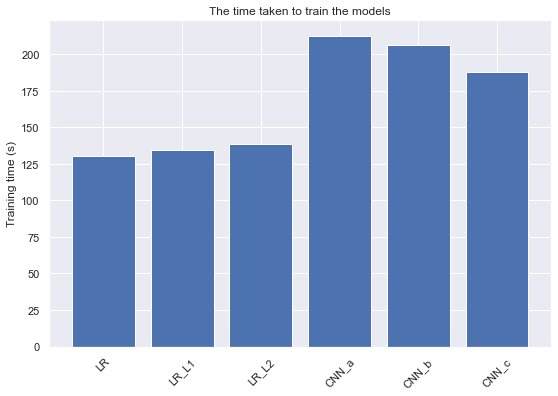

In [47]:
 
labels = ['LR', 'LR_L1', 'LR_L2', 'CNN_a', 'CNN_b', 'CNN_c']
values = [LR_train_time, LR_L1_train_time, LR_L2_train_time, CNN_a_train_time, CNN_b_train_time, CNN_c_train_time]


plt.figure(figsize=(9,6))
 
plt.bar(x=labels,
 
        height=values)
plt.title('The time taken to train the models')
plt.ylabel('Training time (s)')

 
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

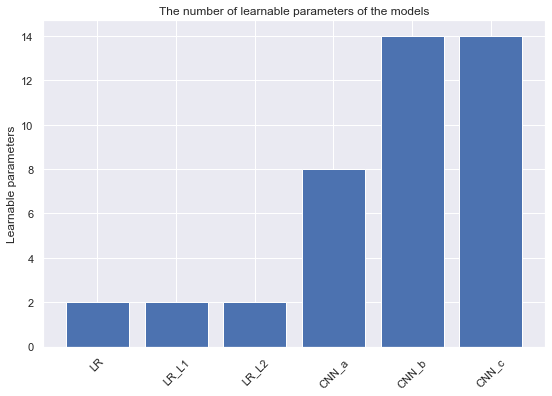

In [48]:

labels = ['LR', 'LR_L1', 'LR_L2', 'CNN_a', 'CNN_b', 'CNN_c']
values = [len(LR_params), len(LR_L1_params), len(LR_L2_params), len(CNN_a_params), len(CNN_b_params), len(CNN_c_params)]


plt.figure(figsize=(9,6))
 
plt.bar(x=labels,
 
        height=values)
plt.title('The number of learnable parameters of the models')
plt.ylabel('Learnable parameters')
 
plt.xticks(rotation=45)

## B2.5b Performance Comparisons

Observations

b) Describe at least two interesting observations

The convolutional neural networks (CNNs) performed better than the logistic regression models on both the training and test data. The CNNs gave accuracies in the region of 86-89% compared to a lower 76% for logistic regression. This improved accuracy is expected as logistic regressions bases the classification on a more generalized linear relationship whereas with the hidden layers in the neural networks they are able to express a more complex non-linear relationship.


Similarly, all of the logistic regression models have almost indistinguishable performances on the test and training data irrespective of the hyperparameters. With all the models having accuracies of 75-76% on the training data and 75% on the test data to 2 significant figures. This is quite surprising as I expected the different penalties used (none, L1 and L2) to have a larger effect on the accuracies and lead to a deviation of at least a few percent.


## B.3 Unsupervised Learning on Fashion-MNIST

## B3.1 PCA and K-means

In [49]:
new_trainset = datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor()) # was previously transform=transform
idx = (new_trainset.targets==7) | (new_trainset.targets==2)
new_trainset.targets = new_trainset.targets[idx]
new_trainset.data = new_trainset.data[idx]
new_trainset_list = list(new_trainset)


In [50]:
# Splitting the new_trainset into the images & labels
# & verifying that 
images, labels = new_trainset.data, new_trainset.targets
labels[:12]

tensor([2, 7, 2, 7, 2, 2, 7, 2, 7, 7, 2, 2])

In [51]:
# Applying PCA to the new trainset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_trainset = list(new_trainset)
X = np.array(X_trainset[:][0][0].numpy()).reshape(1, 28*28)
for i in range(1, len(X_trainset[:])):
    X = np.append(X,np.array(X_trainset[:][i][0].numpy()).reshape(1, 28*28),axis = 0)
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=0.95)
y = pca.fit(X)
cov_matrix = np.dot(X.T, X) / len(X)

for eigenvector in pca.components_[:24]:
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))

278.09973
65.80345
48.727375
29.668642
23.978962
19.655209
13.1243725
10.898949
9.590725
8.650484
7.8367114
7.6716557
7.491312
6.693139
6.4437785
6.2397823
5.954254
5.8685203
5.34663
4.7755446
4.634918
4.5424376
4.1261744
3.8019638


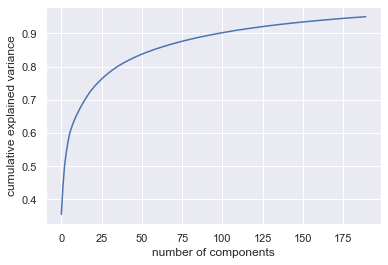

In [52]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## B3.1a

Visualising the top 24 eigenvectors as images

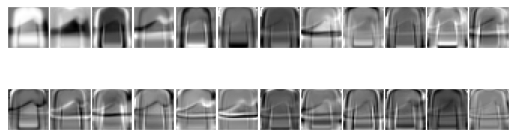

In [53]:
fig, axes = plt.subplots(2,12,figsize=(9,3),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
 ax.imshow(pca.components_[i].reshape(28,28),cmap="gray")



## B3.1b

Using the top 24 PCs to reconstruct 30 images, 15 from each class. Compute and report the RMSE between the reconstructed & original images.

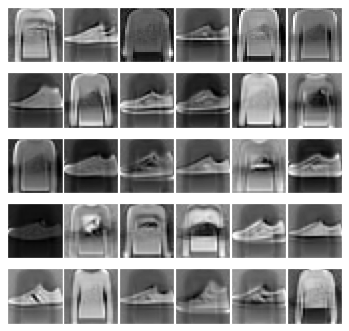

In [54]:
components = pca.transform(X)
projected = pca.inverse_transform(components)
fig, axes = plt.subplots(5,6,figsize=(6,6), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(projected[i].reshape(28,28),cmap="gray")

In [55]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, projected)

0.049682617

 Showing the pairs of reconstructed images & original images. The reconstructed images are on the left-hand side with the original images on the right-hand side.

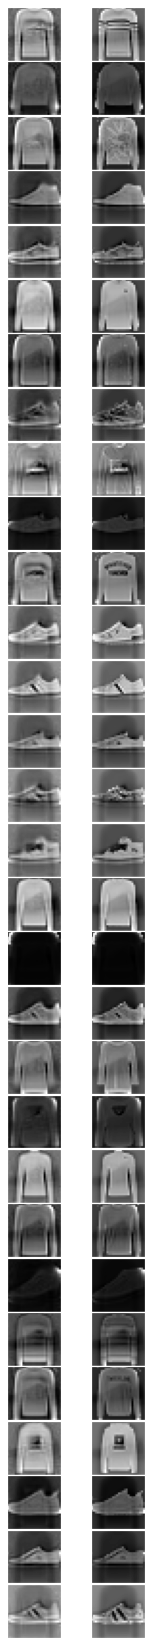

In [56]:
# Showing the pairs of reconstructed images & original images

fig, axes = plt.subplots(30,2,figsize=(3,30), subplot_kw={'xticks':[], 'yticks':[]},
            gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
    ax.imshow(projected[i].reshape(28,28),cmap="gray")
    if (i % 2 != 0):
        ax.imshow(X[i-1].reshape(28,28),cmap="gray")

        

## B3.1c

Plot the PCA representations of all data points in a 2D plane using the top two PCs

In [57]:
pca_2 = PCA(n_components=2)
pca_data = pca_2.fit_transform(X)
pca_Df = pd.DataFrame(data = pca_data
             , columns = ['principal component 1', 'principal component 2'])
pca_Df.tail()

,principal component 1,principal component 2
11995,19.889973,-2.274441
11996,-6.820625,-13.566920
11997,32.470066,-12.124715
11998,-13.759748,-0.679171
11999,4.272490,11.653208


In [58]:
pca_Df['label'] = labels
pca_Df['label'].replace(2, 'Pullover',inplace=True)
pca_Df['label'].replace(7, 'Sneaker',inplace=True)
pca_Df

,principal component 1,principal component 2,label
0,19.106232,0.317031,Pullover
1,-14.969610,-6.178141,Sneaker
2,28.038382,-14.847600,Pullover
3,-18.556488,4.904138,Sneaker
4,29.669628,-6.948659,Pullover
...,...,...,...
11995,19.889973,-2.274441,Pullover
11996,-6.820625,-13.566920,Sneaker
11997,32.470066,-12.124715,Pullover
11998,-13.759748,-0.679171,Sneaker


<Figure size 432x288 with 0 Axes>

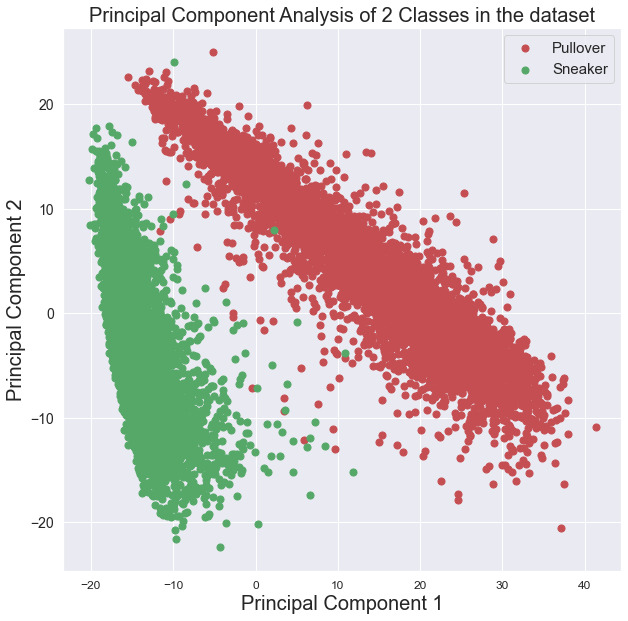

In [59]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.title("Principal Component Analysis of 2 Classes in the dataset",fontsize=20)
targets = ['Pullover', 'Sneaker']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = pca_Df['label'] == target
    plt.scatter(pca_Df.loc[indicesToKeep, 'principal component 1']
               , pca_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

## B3.1d

Using k-means to cluster all the datapoints & visualise these clusters, indicating the centre of each cluster

In [60]:
from sklearn.cluster import KMeans
pca_Dff = pca_Df.drop(['label'], axis=1)
kmeans = KMeans(n_clusters=2)
clusts = kmeans.fit_predict(pca_Dff)


In [61]:
kmeans.cluster_centers_[0]

array([18.746532  ,  0.58469474], dtype=float32)

<Figure size 432x288 with 0 Axes>

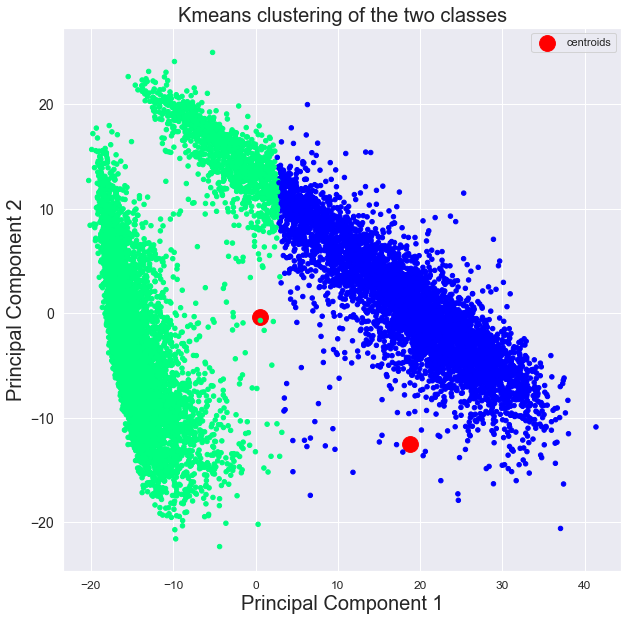

In [62]:
fig = plt.figure()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component 1',fontsize=20)
plt.ylabel('Principal Component 2',fontsize=20)
plt.title("Kmeans clustering of the two classes",fontsize=20)
scatter = ax.scatter(kmeans.cluster_centers_[0],
            kmeans.cluster_centers_[1],
            s = 250,
            marker='o',
            c='red',
            label='centroids')
scatter = ax.scatter(pca_Dff['principal component 1'], pca_Dff['principal component 2'],
                     c=clusts,s=20, cmap='winter')
ax.legend()
plt.show()

## B3.2 Autoencoder

Design new autoencoder with five Conv2d layers and five ConvTranspose2d layers. Train this new autoencoder on all images of these two chosen classes for at least 20 epochs. Plot the mean squared error against the epoch.

In [63]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [64]:
myAE=Autoencoder()
print(myAE)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (9): Sigmoid()
  )
)


In [65]:
params = list(myAE.parameters())
print(len(params))
print(params[0].size())  
print(params[1].size())  
print(params[1])

20
torch.Size([16, 1, 3, 3])
torch.Size([16])
Parameter containing:
tensor([ 0.2139, -0.0999, -0.2985,  0.3047, -0.3304,  0.2785,  0.0303,  0.2174,
         0.1218, -0.2076,  0.3059,  0.2477, -0.2731, -0.2163, -0.0661, -0.2957],
       requires_grad=True)


In [67]:
#Training (optimisation) parameters
torch.manual_seed(1748942)
learning_rate=1e-3
max_epochs = 20


criterion = nn.MSELoss() 

optimizer = torch.optim.Adam(myAE.parameters(), lr=learning_rate, weight_decay=1e-5)
new_trainloader = torch.utils.data.DataLoader(new_trainset, batch_size=128,
                                          shuffle=True)

outputs = []
losses = []

for epoch in range(max_epochs):
    for data in new_trainloader:
        img, label = data
        optimizer.zero_grad()        
        recon = myAE(img)
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()            
    if (epoch % 2) == 0:
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, img, recon),)
    losses.append(loss)

Epoch:1, Loss:0.0498
Epoch:3, Loss:0.0234
Epoch:5, Loss:0.0210
Epoch:7, Loss:0.0180
Epoch:9, Loss:0.0172
Epoch:11, Loss:0.0151
Epoch:13, Loss:0.0135
Epoch:15, Loss:0.0125
Epoch:17, Loss:0.0134
Epoch:19, Loss:0.0128


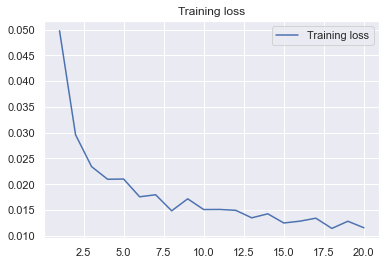

In [68]:

train_epochs = list(range(1,21))
epochs__ = outputs[epoch]
plt.figure()
plt.plot(train_epochs, losses, label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()


## B3.2b

Modifying the autoencoder so the bottleneck has a dimension of 2 only

In [69]:
class Mod_AE(nn.Module):
    def __init__(self):
        super(Mod_AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() 
        )

    def forward(self, x):
        x = self.encoder(x.view(-1, 784))
        x = self.decoder(x)
        return x

In [70]:
mod_AE= Mod_AE()
print(mod_AE)

Mod_AE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (9): Sigmoid()
  )
)


In [71]:
#Training (optimisation) parameters
torch.manual_seed(1748942)
learning_rate=1e-3
max_epochs = 20

#Choose mean square error loss
criterion = nn.MSELoss() 
#Choose the Adam optimiser
optimizer = torch.optim.Adam(myAE.parameters(), lr=learning_rate, weight_decay=1e-5)
new_trainloader = torch.utils.data.DataLoader(new_trainset, batch_size=128,
                                          shuffle=True)
#Storage
outputs = []
losses = []
#Start training
for epoch in range(max_epochs):
    for data in new_trainloader:
        # get the inputs; data is a list of [inputs, labels]
        img, label = data
        optimizer.zero_grad()        
        recon = myAE(img)
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()            
    if (epoch % 2) == 0:
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, img, recon),)
    losses.append(loss)



Epoch:1, Loss:0.0131
Epoch:3, Loss:0.0111
Epoch:5, Loss:0.0121
Epoch:7, Loss:0.0113
Epoch:9, Loss:0.0110
Epoch:11, Loss:0.0098
Epoch:13, Loss:0.0094
Epoch:15, Loss:0.0084
Epoch:17, Loss:0.0090
Epoch:19, Loss:0.0092
